**Thành viên:**  
- Huỳnh Minh Thuận - 22110217  
- Trương Minh Thuật - 22110218  
- Nguyễn Phạm Anh Trí - 22110236  
- Nguyễn Minh Trí - 22110235  
- Nguyễn Đình Tiến - 22110230 

**Table of Contents**  
1. [Introduction](#1.-introduction)  
2. [Data Collection and Ingestion](#2.-data-collection-and-ingestion)  
    2.1 [Data Retrieval Functions and Execution Process](#2.1-data-retrieval-functions-and-execution-process)  
    2.2 [Daily Data Scraping and Storing Strategy](#2.2-daily-data-scraping-and-storing-strategy)  
3. [Three-Layer Data Lake Processing](#3.-three-layer-data-lake-processing)  
    3.1 [Bronze Layer Procesing](#3.1-bronze-layer-processing)  
    3.2 [Silver Layer Procesing](#3.2-silver-layer-processing)  
    3.3 [Gold Layer Procesing](#3.3-gold-layer-processing)  
4. [Data Warehouse Storing](#4.-data-warehouse-storing)  
5. [Exploratory Data Analysis](#5.-exploratory-data-analysis)  
6. [Machine Learning for Recommendation System](#6.-machine-learning-for-recommendation-system)  
7. [Application with Streamlit](#7.-application-with-streamlit)  

# Introduction  
- Trong thế giới hiện đại ngày nay, âm nhạc là một phần không thể thiếu, nó tạo ra sự kết nối về cảm xúc trong mỗi chúng ta. Nhóm chúng mình quyết định sẽ xây dựng một kiến trúc end-to-end data pipelines bao gồm các công việc như thu thập, cào dữ liệu về nghệ sĩ, bài hát, sau đó xử lý, lưu trữ, phân tích, báo cáo và xây dựng hệ thống đề xuất bài hát dựa theo nhu cầu của người dùng. 

- **Data sources**: Nguồn dữ liệu sẽ được thu thập từ https://kworb.net/itunes/extended.html, bao gồm tên của 15,000 nghệ sĩ hàng đầu được cập nhật hàng ngày. Sau đó, ta sẽ sử dụng **Spotify API** để lấy thông tin về nghệ sĩ, album, bài hát và các đặc điểm của bài hát dựa trên danh sách tên nghệ sĩ đã thu thập được từ trang web Kworb.net.

- **Tools**:
    - **Python**: Ngôn ngữ lập trình chính.
    - **Docker**: Dùng để chạy các container, đảm bảo môi trường nhất quán và có thể mở rộng.
    - **MongoDB**: Được sử dụng làm Database để lưu các dữ liệu thu thập từ việc crawl và request API.
    - **HDFS**: Một phần trong kiến trúc Hadoop, được sử dụng làm Data Lake để lưu trữ dữ liệu để xử lý.
    - **Snowflake**: Kho dữ liệu trên nền tảng đám mây (Cloud-Based Data Warehouse).
    - **PowerBI**: Công cụ hiển thị dữ liệu và cung cấp cái nhìn tổng quan toàn diện.
    - **Airflow**: Một framework sử dụng ngôn ngữ Python để lập lịch và chạy các task.

- **Architecture**:    
![My Image](./images/Architecture.png)
- **Link Source code**:
*https://github.com/mjngxwnj/Big-Data-for-Music-Recommendation-System*

# Data Collection and Ingestion  
We start by collecting data from **Kworb.net**, which includes **15,000** artist name, then use the **Spotify API** to fetch more music-related details. This data is stored in **MongoDB** for further processing and analysis.

## Data Retrieval Functions and Execution Process
### Get data from **Kworb.net**  
- **Step 1**: We get the link from the **Kworb.net** and use pandas to get data from the site and use the read html function (**pandas.read_html(url)**) to read all tables from the returned web page. Function pandas.read_html will return a list of tables available on the web page.  

- **Step 2**: Because the information we need to get is from the first table, we proceed to get the first table with 2 columns: **Pos** corresponding to the artist's position on the rankings table and  **Artist** corresponding to the artist's name.  

- **Step 3**: We save the 2 columns we have retrieved to **MongoDB** to proceed with the next steps.  

### Get Information of **Artist**:  
- **Step 1**: We get the artist's name from the **MongoDB** database after filtering out artists with no information. We use the spotipy library to connect the api to spotify and get that artist's information. To connect the api with spotify we need 2 things: client id and client secret to connect  

- **Step 2**: We use the function **sp.search** to get the artist's information. This function returns a dictionary with the artist's information.  

- **Step 3**: We put the information into the corresponding columns and transfer that information back to MongoDB.  
    
### Get Information of **Artist's Album** and **Track**:  

- **Step 1**: After obtaining the artist's data, including artist id, we use artist id to get data about the album id and save that data into a list for continued use.  

- **Step 2**: To optimize the number of api calls (avoid overload), we divide the album id list into smaller lists to call the api for each sublist. By using the **spotipy.album** function we can get data for 20 albums and tracks contained in that album in one api call.  

- **Step 3**: We save all the data to the **MongoDB** database.  

### Get Information of **Track Feature**:  
- **Step 1**: Using the data from the previous step, we have obtained the track id to get more features of each track.  

- **Step 2**: Also to optimize the number of api calls, we divide the list of tracks into sublists to call the api from spotify. By using the **spotipy.audio_features** function we can get the audio features of 100 tracks in one api call.  

- **Step 3**: We save all the data to the **MongoDB** database.  

![Image](./images/crawl_api.jpg)

## Daily Data Scraping and Storing Strategy
### Initial Data Scraping and Storing   
- Sau lần thử scraping data ở ngày đầu, ta thấy được việc crawl xong 15,000 tên nghệ sĩ thì phải mất rất nhiều lượt call **Spotify API** để lấy thông tin của 15,000 người(có thể bị block API).  

- Để giải quyết vấn đề này, ta sẽ chia 15,000 tên nghệ sĩ trong 3 ngày, mỗi ngày ta sẽ chỉ lấy 5,000 tên nghệ sĩ để call **Spotify API** và lấy thông tin **artist**, **albums**, **tracks**, **track features**, sau đó lưu vào CSV file. Khi toàn bộ 15,000 tên nghệ sĩ đã được sử dụng để request API, ta sẽ load toàn bộ csv file lên MongoDB, và gọi bộ data này là **initial data**.  

- Các hàm call để lấy data sẽ tương tự như trên, và ta sẽ lưu bằng csv trước thay vì MongoDB.  
 
### Subsequent Data Scraping and Storing  
- Ở những ngày tiếp theo (sau khi đã có được toàn bộ dữ liệu của 15,000 nghệ sĩ), nếu chúng ta tiếp tục crawl 15,000 tên nghệ sĩ mới ở Kworb sau đó dùng **Spotify API** để lấy thông tin **album**, **track**, chúng ta sẽ gặp vấn đề data duplication, vì các nghệ sĩ nổi tiếng như Taylor Swift thường xuyên nằm trong bảng xếp hạng, dẫn đến việc lặp lại dữ liệu của họ nhiều lần khi crawl hằng ngày.  
- Để tránh khỏi vấn đề này, ta sẽ crawl 15,000 tên nghệ sĩ mới (**daily artist names**), sau đó thực hiện **_Left Anti Join_** với 15,000 tên nghệ sĩ cũ (**old artist names**) trong MongoDB để tìm ra được những nghệ sĩ mới (chưa nằm trong bộ dữ liệu), gọi là **new artist names**.  

In [ ]:
def load_daily_artist_name_mongoDB(Execution_date: str):
    with mongoDB_client(username = 'huynhthuan', password = 'password') as client:
        client_operations = mongoDB_operations(client)

        """ Đọc dữ liệu về danh sách tên nghệ sĩ cũ từ MongoDB"""
        old_artist_name_data = client_operations.read_data(database_name = 'music_database', 
                                                           collection_name = 'artist_name_collection')    
        old_artist_name_data = old_artist_name_data[['Artist']]
        old_artist_name_data.rename(columns = {'Artist': 'Old_Artist'}, inplace = True)

        """ Bắt đầu crawl tên nghệ sĩ mới """
        new_artist_name_data = crawl_artist_name(Execution_date)

        """ Thực hiện Left Anti Join để tìm ra các nghệ sĩ có ở new artist names nhưng k có trong 
            old arist names -> daily artist names """
        daily_artist_name_data = pd.merge(old_artist_name_data, new_artist_name_data, left_on = 'Old_Artist', 
                                                                                      right_on = 'Artist', how = 'right')
        daily_artist_name_data = daily_artist_name_data[daily_artist_name_data['Old_Artist'].isnull()] \
                                                                            [['Pos', 'Artist', 'Execution_date']]
        daily_artist_name_data = daily_artist_name_data.head(3000)
        
        """ Sau đó ta sẽ load daily arist names vào MongoDB """
        client_operations.insert_data(database_name = 'music_database', collection_name = 'artist_name_collection', 
                                      data = daily_artist_name_data)

![Image](./images/leftanti_join_artistname.png)

- Chiến lược này giúp chúng ta sẽ chỉ lấy các artist chưa có trong bộ dữ liệu để dùng **Spotify API** và lấy thông tin album track -> Hạn chế duplicates, và giảm thiểu số lượng request API. (Sau khi perform left anti join thì số lượng artist names hằng ngày ~3,000).  

- Tên nghệ sĩ mới sẽ được lưu vào MongoDB, sau đó lấy từ MongoDB để gọi Spotify API và lưu dữ liệu nghệ sĩ, album, track và tiếp tục lưu vào MongoDB. Ta sẽ thêm cột **execute_date** để theo dõi ngày chạy dữ liệu và lấy dữ liệu tương ứng để gọi API (tránh lấy data của những ngày trước đó để gọi **Spotify API**).  

![Image](./images/daily_crawl_data.png) 

# Three-Layer Data Lake Processing  
Ta sẽ dùng **HDFS** (**Hadoop Distributed File System**) để lưu các bộ dữ liệu được process và transform, và ta sẽ gọi kho dữ liệu này là **Data Lake**.  

Cấu trúc data lake processing system của chúng ta sẽ thiết kế với 3 lớp chính: **Bronze**, **Silver** and **Gold**. Mỗi lớp đóng vai trò quan trọng khác nhau để lưu và xử lý dữ liệu theo từng cấp cho các bước analysis, reporting và xây dựng mô hình Machine Learning.

## Bronze Layer Processing
Ở giai đoạn này, dữ liệu được sẽ được lấy từ **MongoDB** sau khi gọi **Spotify API** để thu thập thông tin về **artists**, **albums**, **tracks**, và **track features**. Sau đó, ta sẽ apply các schemas được định nghĩa trước vào các bộ dữ liệu để đảm bảo đúng kiểu dữ liệu của từng cột.

Các schema được định nghĩa (**Pyspark Schema**) sẽ có dạng như sau: 

In [ ]:
""" Function for getting schemas. """
def get_schema(table_name: str) -> StructType:
    """ Artist schema. """
    artist_schema = [StructField('Artist_ID',     StringType(), True),
                    StructField('Artist_Name',    StringType(), True),
                    StructField('Genres',         ArrayType(StringType(), True), True),
                    StructField('Followers',      IntegerType(), True),
                    StructField('Popularity',     IntegerType(), True),
                    StructField('Artist_Image',   StringType(), True),
                    StructField('Artist_Type',    StringType(), True),
                    StructField('External_Url',   StringType(), True),
                    StructField('Href',           StringType(), True),
                    StructField('Artist_Uri',     StringType(), True),
                    StructField('Execution_date', DateType(), True)]
    #applying struct type
    artist_schema = StructType(artist_schema)

Tương tự cho các bảng **Album**, **Track** và **Track Feature**.  

Bên cạnh đó, ở quá trình này, ta cũng sẽ áp dụng chiến lược **incremental load** để nạp dữ liệu theo từng ngày dựa theo cột **Execution_date** -> Giảm thiểu lượng data cần xử lý, cần transform và load. 

![Image](./images/incremental_load.png)  

Ta có thể thấy chỉ những dữ liệu được crawl từ một ngày cụ thể mới được đọc - xử lý - lưu vào **Data Lake** (Không đọc - xử lý - lưu các dữ liệu crawl ở những ngày trước).

Đây là hàm đọc dữ liệu từ **MongoDB** (sau khi scrape), xử lý đơn giản, áp dụng schema, lọc dữ liệu theo chiến lược **incremental load** bằng tham số đầu vào **Execution_date** và load vào **Data Lake** - **Bronze Layer**.

In [ ]:
""" Applying schemas and loading data from MongoDB into HDFS."""
def bronze_layer_processing(Execution_date: str):
    #get spark Session
    with get_sparkSession(appName = 'Bronze_task_spark') as spark:
        """------------------------ BRONZE ARTIST ------------------------"""
        """ Đọc dữ liệu từ MongoDB """
        artist_data = read_mongoDB(spark, database_name = 'music_database', collection_name = 'artist_collection')

        """ Lọc ra các dữ liệu đã crawl ở ngày hiện tại """
        artist_data = artist_data.filter(artist_data['Execution_date'] == Execution_date)

        """ Bắt đầu xử lý """
        print("Starting bronze preprocessing for artist data...")
        #preprocessing before loading data
        try:
            artist_data = artist_data.withColumn('Genres', split(col('Genres'), ",")) \
                                     .withColumn('Followers', col('Followers').cast('int')) \
                                     .withColumn('Popularity', col('Popularity').cast('int')) \
                                     .withColumn('External_Url', get_json_object(col('External_Url'),'$.spotify')) \
                                     .withColumn('Execution_date', col('Execution_date').cast('date'))
            #reorder columns after reading 
            artist_data = artist_data.select('Artist_ID', 'Artist_Name', 'Genres', 
                                            'Followers', 'Popularity', 'Artist_Image', 
                                            'Artist_Type', 'External_Url', 'Href', 'Artist_Uri', 'Execution_date')
            #applying schema        
            artist_data = spark.createDataFrame(artist_data.rdd, schema = get_schema('artist'))

            print("Finished bronze preprocessing for artist data.")

            #upload data into HDFS
            write_HDFS(spark, data = artist_data, direct = 'bronze_data/bronze_artist', 
                       file_type = 'parquet', mode = "append", partition = 'Execution_date')
        except Exception as e:
            print(f"An error occurred while preprocessing bronze data: {e}")

## Silver Layer Processing  
Ở giai đoạn này, ta sẽ đọc dữ liệu từ **Bronze Layer Data Storage**(dữ liệu được xử lý đơn giản và áp dụng schema để định chuẩn kiểu dữ liệu các cột), sau đó thực hiện các quá trình xử lý dữ liệu, bao gồm:  
- **Drop columns**: drop các cột không cần thiết.  
- **Drop null columns**: drop các dòng chứa giá trị null dựa vào subset column được chọn.  
- **Fill null**: thay thế giá trị null bằng các giá trị cụ thể.  
- **Drop duplicate**: drop các dòng bị trùng lắp dữ liệu dựa vào subset column được chọn.  
- **Handle nested**: xử lý các dòng có cấu trúc nested data.  
- **Rename column**: Đổi tên cột cần thiết.  

Để dễ dàng quản lý và tránh các thao tác xử lý dữ liệu lặp đi lặp lại cho từng bảng, ta sẽ tạo 1 **SilverLayer Class**, đây là lớp sẽ thực hiện các quá trình xử lý dữ liệu nêu trên cho từng bảng dữ liệu.  

Với mỗi bảng cần xử lý, ta chỉ cần áp dụng lớp này và truyền các tham số cần thiết như bảng dữ liệu, danh sách cột cần xóa, cần rename, subset column để drop null,...

In [ ]:
""" Create SilverLayer class to process data in the Silver layer. """
class SilverLayer:
    #init 
    def __init__(self, data: pyspark.sql.DataFrame, 
                 drop_columns: list = None, 
                 drop_null_columns: list = None,
                 fill_nulls_columns: dict = None,
                 duplicate_columns: list = None,
                 nested_columns: list = None,
                 rename_columns: dict = None,
                 ):
        #check valid params
        if data is not None and not isinstance(data, pyspark.sql.DataFrame):
            raise TypeError("data must be a DataFrame!")
        if drop_columns is not None and not isinstance(drop_columns, list):
            raise TypeError("drop_columns must be a list!")
        if drop_null_columns is not None and not isinstance(drop_null_columns, list):
            raise TypeError("drop_null_columns must be a list!")
        if fill_nulls_columns is not None and not isinstance(fill_nulls_columns, dict):
            raise TypeError("handle_nulls must be a dict!")
        if duplicate_columns is not None and not isinstance(duplicate_columns, list):
            raise TypeError("duplicate_columns must be a list!")
        if nested_columns is not None and not isinstance(nested_columns, list):
            raise TypeError("handle_nested must be a list!")
        if rename_columns is not None and not isinstance(rename_columns, dict):
            raise TypeError("rename_columns must be a dict!")
        """Initialize class attributes for data processing."""
        self._data = data
        self._drop_columns = drop_columns
        self._drop_null_columns = drop_null_columns
        self._fill_nulls_columns = fill_nulls_columns
        self._duplicate_columns = duplicate_columns
        self._nested_columns = nested_columns
        self._rename_columns = rename_columns


    """ Method to drop unnecessary columns. """
    def drop(self):
        self._data = self._data.drop(*self._drop_columns)

    """ Method to drop rows based on null values in each column. """
    def drop_null(self):
        self._data = self._data.dropna(subset = self._drop_null_columns, how = "all")

    """ Method to fill null values. """
    def fill_null(self):
        for column_list, value in self._fill_nulls_columns.items():
            self._data = self._data.fillna(value = value, subset = column_list)
    """ Method to rename columns. """
    def rename(self):
        for old_name, new_name in self._rename_columns.items():
            self._data = self._data.withColumnRenamed(old_name, new_name)

    """ Method to handle duplicates. """
    def handle_duplicate(self):
        self._data = self._data.dropDuplicates(self._duplicate_columns)

    """ Method to handle nested. """
    def handle_nested(self):
        for column in self._nested_columns:
            self._data = self._data.withColumn(column, explode_outer(column)) \
                                   .withColumn(column, ltrim(column))
    
    """ Main processing. """
    def process(self) -> pyspark.sql.DataFrame:
        #drop unnecessary columns
        if self._drop_columns:
            self.drop() 

        #drop rows contain null values for each col
        if self._drop_null_columns:
            self.drop_null()

        #fill null values
        if self._fill_nulls_columns:
            self.fill_null()
        
        #handle duplicate rows
        if self._duplicate_columns:
            self.handle_duplicate()

        #handle nested columns 
        if self._nested_columns:
            self.handle_nested()

        #rename columns
        if self._rename_columns:
            self.rename()

        return self._data

Sau khi có được lớp **SilverLayer Class**, ta sẽ tiến hành đọc dữ liệu từ lớp **Bronze Layer**, áp dụng lớp này để xử lý dữ liệu, và nạp dữ liệu vào **Silver Layer Storage**.  

Đây là hàm xử lý dữ liệu ở lớp Silver Layer:

In [ ]:
""" Processing silver artist data. """
def silver_artist_process(spark: SparkSession):
    """ Đọc dữ liệu từ Bronze Layer Storage """
    bronze_artist = read_HDFS(spark, HDFS_dir = "bronze_data/bronze_artist", file_type = 'parquet')

    """ Sử dụng lớp SilverLayer """
    silver_artist = SilverLayer(data = bronze_artist, 
                                drop_columns       = ['Artist_Type', 'Href', 'Artist_Uri', 'Execution_date'],
                                drop_null_columns  = ['Artist_ID'], 
                                fill_nulls_columns = {'Followers': 0,
                                                      'Popularity': 0},
                                duplicate_columns  = ['Artist_ID'],
                                nested_columns     = ['Genres'],
                                rename_columns     = {'Artist_ID': 'id',
                                                      'Artist_Name': 'name',
                                                      'Genres': 'genres',
                                                      'Followers': 'followers',
                                                      'Popularity': 'popularity',
                                                      'Artist_Image': 'link_image',
                                                      'External_Url': 'url'})
    
    """ Gọi phương thức process của SilverLayer class để tiến hành xử lý dữ liệu """
    print("Processing for 'silver_artist' ...")
    silver_artist = silver_artist.process()
    print("Finished processing for 'silver_artist'.")
    """ Upload data (silver data) vào Silver Layer Storage """
    write_HDFS(spark, data = silver_artist, direct = "silver_data/silver_artist", file_type = 'parquet')

Xử lý tương tự cho **bronze_album**, **bronze_track** và **bronze_track_feature**.

## Gold Layer Processing  
Ở bước này, sau khi bộ dữ liệu được xử lý ở giai đoạn **Silver Layer** stage, ta sẽ thực hiện quá trình kết hợp các bảng để tạo ra một lược đồ tuân theo cấu trúc **Snowflake schema**, được chuẩn hóa đến mức cao nhất - **3NF**, trong đó **fact table** sẽ là bảng track, và lược đồ này sẽ được áp dụng để tổ chức dữ liệu trong **Data Warehouse**.  

Đây là lược đồ mà chúng ta mong muốn:  

![Image](./images/schema.jpg)

Trong đó, chúng ta sẽ có 5 bảng tương ướng với 5 bộ dữ liệu:  
- **Fact track**: Đây là bảng chính của bộ dữ liệu, chứa thông tin về toàn bộ bài hát, và được thêm vào các cột khóa ngoại nối đến toàn bộ khóa chính của các bảng dữ liệu khác.  
- **Dim artist**: Đây là bảng dữ liệu về các nghệ sĩ và thông tin tương ứng.  
- **Dim album**: Đây là bảng dữ liệu về album, chứa các thông tin như tên, bản quyền, ngày phát hành,...  
- **Dim track feature**: Đây là bảng chứa dữ liệu về các feature của 1 track, bao gồm loudness, mode, tempo,...  
- **Dim genres**: Đây là bảng chứa thông tin về toàn bộ thể loại âm nhạc của các nghệ sĩ, bao gồm pop, rock,...  
- **Dim artist-genres**: Vì mối quan hệ giữa **artist** và **genres** là mối quan hệ **many-to-many** (1 nghệ sĩ có thể có nhiều thể loại âm nhạc, và 1 thể loại âm nhạc cũng có thể thuộc về nhiều nghệ sĩ), bảng **dim artist-genres** là cầu nối giữa 2 **artist** và **genres**.  

Như vậy, ta sẽ lấy bộ dữ liệu đã được làm sạch ở **Silver Layer Storage**, và thực hiện một số quá trình join, aggregation để có được một bộ dữ liệu được tổ chức theo lược đồ mà ta đã chuẩn bị.  

In [ ]:
""" Gold layer. """
def gold_layer_processing():
    with get_sparkSession('Gold_task_spark') as spark:
        #Đọc các dữ liệu từ Silver Layer Storage
        silver_artist = read_HDFS(spark, HDFS_dir = 'silver_data/silver_artist', file_type = 'parquet')
        silver_artist.cache()
        silver_album = read_HDFS(spark, HDFS_dir = 'silver_data/silver_album', file_type = 'parquet')
        silver_album.cache()
        silver_track = read_HDFS(spark, HDFS_dir = 'silver_data/silver_track', file_type = 'parquet')
        silver_track.cache()
        silver_track_feature = read_HDFS(spark, HDFS_dir = 'silver_data/silver_track_feature', file_type = 'parquet')
        silver_track_feature.cache()

        """ Create dim_genres table. """
        dim_genres = silver_artist.select('genres').distinct()
        dim_genres = dim_genres.filter(col('genres').isNotNull())
        #add primary key
        dim_genres = dim_genres.withColumn("id", monotonically_increasing_id()) \
                               .withColumn("id", concat(lit("gns"), col('id')))
        #reorder columns
        dim_genres = dim_genres.select("id", "genres")
        #load data into HDFS
        write_HDFS(spark, data = dim_genres, direct = 'gold_data/dim_genres', file_type = 'parquet')


        """ Create dim_artist table. """
        #just drop genres column and distinct row
        dim_artist = silver_artist.drop('genres').distinct()
        write_HDFS(spark, data = dim_artist, direct = 'gold_data/dim_artist', file_type = 'parquet')


        """ Create dim_artist_genres table. """
        #select necessary columns in artist table
        dim_artist_genres = silver_artist.select('id', 'genres') \
                                         .withColumnRenamed('id', 'artist_id')
        #joining tables to map artist IDs and genre IDs
        dim_genres = read_HDFS(spark, HDFS_dir = 'gold_data/dim_genres', file_type = 'parquet')
        dim_artist_genres = dim_artist_genres.join(dim_genres, on = 'genres', how = 'left') \
                                             .withColumnRenamed('id', 'genres_id')
        #drop genres column
        dim_artist_genres = dim_artist_genres.drop('genres')
        #load data into HDFS
        write_HDFS(spark, data = dim_artist_genres, direct = 'gold_data/dim_artist_genres', file_type = 'parquet')


        """ Create dim_album table. """
        #just drop unnecessary columns 
        dim_album = silver_album.drop('artist', 'artist_id', 'total_tracks', 'release_date_precision')
        #load data into HDFS
        write_HDFS(spark, data = dim_album, direct = 'gold_data/dim_album', file_type = 'parquet')


        """ Create dim_track_feature table. """
        #we don't need to do anything since the dim_track_feature table is complete
        #load data into HDFS
        write_HDFS(spark, data = silver_track_feature, direct = 'gold_data/dim_track_feature', file_type = 'parquet')


        """ Create fact_track table. """
        #drop album name and rename track id column
        fact_track = silver_track.drop('album_name') \
                                 .withColumnRenamed('id', 'track_id')
        #get artist ID from silver album table to create a foreign key for the fact_track table
        silver_album = silver_album.select('id', 'artist_id') \
                                   .withColumnRenamed('id', 'album_id')
        fact_track = fact_track.join(silver_album, on = 'album_id', how = 'inner')
        #reorder columns
        fact_track = fact_track.select('track_id', 'artist_id', 'album_id', 'name', 'track_number', 
                                        'disc_number', 'duration_ms', 'explicit', 'url', 'restriction', 'preview')
        #load data into HDFS
        write_HDFS(spark, data = fact_track, direct = 'gold_data/fact_track', file_type = 'parquet')

Qua các bước join bảng và loại bỏ thêm các cột không cần thiết, đồng thời tạo thêm các cột khóa chính, khóa ngoại cho mỗi bảng, Ta sẽ lưu toàn bộ dữ liệu vào **Gold Layer Storage**. 

# Data Warehouse Storing  
Trong dự án này, kho dữ liệu **Data Warehouse** mà chúng ta chọn sẽ là **Snowflake** - một **Cloud-Based Data Warehouse**. **Snowflake** khá mạnh mẽ cho việc lưu trữ dữ liệu clean, báo cáo và phân tích.   

Sau khi bộ dữ liệu ở lớp **Gold Layer** đã hoàn thành, ta sẽ cần khởi tạo **Database**, **Schema** và **Table** ở **Snowflake Data Warehouse**. Sau đó, ta sẽ tải toàn bộ dữ liệu từ lớp **Gold Layer** vào **Snowflake**. Để đơn giản, ta chỉ cần dùng **Spark** để đọc dữ liệu đã được lưu ở **Gold Layer Storage** trong **Data Lake**, sau đó load dữ liệu lên **Data Warehouse**.

In [ ]:
def load_data_Snowflake():
    with get_sparkSession("snowflake_load_data_spark") as spark:
        dim_artist = read_HDFS(spark, HDFS_dir = 'gold_data/dim_artist', file_type = 'parquet')
        write_SnowFlake(spark, data = dim_artist, 
                               table_name = 'SPOTIFY_MUSIC_DB.SPOTIFY_MUSIC_SCHEMA.dim_artist')

        dim_genres = read_HDFS(spark, HDFS_dir = 'gold_data/dim_genres', file_type = 'parquet')
        write_SnowFlake(spark, data = dim_genres, 
                               table_name = 'SPOTIFY_MUSIC_DB.SPOTIFY_MUSIC_SCHEMA.dim_genres')

        dim_artist_genres = read_HDFS(spark, HDFS_dir = 'gold_data/dim_artist_genres', file_type = 'parquet')
        write_SnowFlake(spark, data = dim_artist_genres, 
                               table_name = 'SPOTIFY_MUSIC_DB.SPOTIFY_MUSIC_SCHEMA.dim_artist_genres')

        dim_album = read_HDFS(spark, HDFS_dir = 'gold_data/dim_album', file_type = 'parquet')
        write_SnowFlake(spark, data= dim_album,
                               table_name = 'SPOTIFY_MUSIC_DB.SPOTIFY_MUSIC_SCHEMA.dim_album')

        dim_track_feature = read_HDFS(spark, HDFS_dir = 'gold_data/dim_track_feature', file_type = 'parquet')
        write_SnowFlake(spark, data = dim_track_feature, 
                               table_name = 'SPOTIFY_MUSIC_DB.SPOTIFY_MUSIC_SCHEMA.dim_track_feature')

        fact_track = read_HDFS(spark, HDFS_dir = 'gold_data/fact_track', file_type = 'parquet')
        write_SnowFlake(spark, data = fact_track, 
                               table_name = 'SPOTIFY_MUSIC_DB.SPOTIFY_MUSIC_SCHEMA.fact_track')

# Exploratory Data Analysis  
Sau khi hoàn thành một hệ thống **data pipelines** hoàn chỉnh, ta sẽ trực quan hóa và phân tích về bộ dữ liệu của chúng ta. Bộ dữ liệu dùng cho công việc **EDA** sẽ lấy ở lớp **Silver Layer**, đảm bảo bộ dữ liệu vẫn còn đầy đủ các cột quan trọng để dễ dàng kết hợp bảng và phân tích. 

- Chúng ta sẽ sử nhóm các nghệ sĩ theo độ nổi tiếng của họ và chỉ lấy ra 10 người nổi tiếng nhất và sau đó là sử dụng WordCloud để vẽ ra với WordCloud thì khi tên của người nghệ sĩ nào càng to thì đồng nghĩa với việc người nghệ sĩ đó có độ nổi tiếng cao nhất.  

![Image](./images/wordcloud_artist.png)

- Tiếp theo là chúng ta sẽ vẽ barplot các nghệ sĩ nhưng mà lần này là dựa theo lượt followers của người đó trên nền tảng Spotify và ta thấy được rằng người nghệ sĩ có lượt followers nhiều nhất là 1 người của nước Ấn Độ “Arijit Singh”.  

![Image](./images/top_followers.png)

- Tiếp là chúng ta sẽ nhóm các bài hát dựa trên thể loại của bài hát và sau đó là đếm số lần xuất hiện của mỗi thể loại và chọn ra 5 thể loại mà xuất hiện nhiều nhất trong dataset của chúng ta để thấy được 5 thể loại nổi tiếng nhất và cũng không quá bất ngờ ở đây thì “pop” là thể loại đứng đầu tiên. Nhưng có thể thấy rằng ở vị trí top 5 là “rap” có thể đánh giá rằng rap hiện nay đang là 1 thể loại đang phát triển rất nhanh chóng.  

![Image](./images/popular_genres.png)


- Chúng ta sẽ nhóm các tên album name dựa trên độ phổ biến và ở đây ta có thể thấy rằng album “Short n' Sweet” của Sabrina Carpenter là phổ biến nhất hoặc có thể nói là được nhiều người yêu thích nhất.

![Image](./images/popular_albums.png)

- Ta sẽ đếm số album mà phát hành trong thời dataset thì ở đây ta sẽ chia ra những năm < 2000 và những năm >= 2000, cụ thể là chia ra làm 2 thế kỉ. Thì có thể đánh giá được rằng thị trường âm nhạc ngày càng phát triển khi mỗi năm là số lượng bài phát hành trở nên nhiều hơn.  

![Image](./images/albums_released.png) 

- Mặc dù không nằm trong album có độ nổi tiếng cao nhưng album “Abbado: Mozart” lại có số bài hát nhiều nhất trong 1 album với 430 bài.  

![Image](./images/album_with_most_tracks.PNG)

- Bên cạnh đó, với những ngày phát hành của các album, ta sẽ biết được thời gian hoạt động của từng nghệ sĩ. Ta sẽ phân tích và trực quan hóa những nghệ sĩ có thời gian hoạt động dài nhất dựa theo thời gian phát hành album của họ.  
![Image](./images/artist_longevity.png)  

Đây là một số thông tin cơ bản ta có thể hiểu được qua việc phân tích và trực quan hóa về bộ dữ liệu của chúng ta. Toàn bộ source code và những phân tích khác còn lại sẽ nằm trong thư mục **notebook/EDA.ipynb**.

# Machine Learning for Recommendation System

### Tổng quan:
Với việc xây dựng mô hình recommendation, chúng tôi sẽ chia ra làm 2 lựa chọn cho người dùng. Với 2 lựa chọn này thì sẽ tương ứng với 2 thuật toán mà chúng tôi sẽ triển khai. Thuật toán đầu tiên sẽ là **"Content-Based Filtering (CBF)"** và thuật toán thứ 2 là 1 thuật toán rất phổ biến đó là **"K-means clustering"**. Chúng tôi sẽ chia phần xây dụng model này làm 2 phần chính là Data Cleaning/Preprocessing và Building Model

### Part 1: Data Cleaning/ Preprocessing
- Ở đây chúng ta sẽ bỏ đi những cột không cần thiết cho việc xây dựng model, cụ thể là những cột như **release date**, **release date precision**, **total tracks**, **album type**, và **time signature**.
- Tiếp theo đó, ta sẽ kiểm tra xem các cột có giá trị null. Với các cột là **song_name** và các cột đặc trưng của 1 bài hát như **danceability**, **valance**, **energy**, **loudness**, **tempo**,.... Nếu như các này mà có giá trị rỗng thì ta sẽ phải bỏ đi những giá trị ở hàng đó hay còn gọi là (drop subset) bởi vì những giá trị này rất quan trọng đối với việc xây dựng mô hình recommendation, cứ tưởng tượng nếu **song_name** mà rỗng thì làm gì có tên bài hát mà để gợi ý cho users hoặc nếu đặt trưng của 1 bài hát không có thì sẽ ảnh hưởng đến thuật toán đàu tiên ngay bên dưới tôi sẽ mô tả.

### Part 2.1: Building model using Content-Based Filtering (CBF)

#### Tổng quan về thuật toán:
- Lọc dựa trên nội dung cung cấp các đề xuất được thiết kế riêng bằng cách tập trung vào sở thích cá nhân, căn chỉnh hiệu quả các tùy chọn với sở thích và mối quan tâm riêng của từng người dùng.
- Điều này thường đạt được thông qua các kỹ thuật như độ tương đồng cosin, đo lường mức độ tương đồng giữa vectơ người dùng (biểu thị sở thích của người dùng) và hồ sơ mục.
- Đặc biệt, mô hình không cần bất kỳ dữ liệu nào về những người dùng khác, vì các đề xuất dành riêng cho người dùng này. Điều này giúp dễ dàng mở rộng quy mô cho nhiều người dùng hơn.
- Mô hình có thể nắm bắt được sở thích cụ thể của người dùng và có thể đề xuất các mục thích hợp mà rất ít người dùng khác quan tâm.

#### Triển khai:
Chúng ta sẽ bám sát vào thể loại nhạc và đặc điểm của từng bài hát để gợi ý cho người nghe

- **Step 1:** Ta sẽ thay các giá trị null ở cột **genres** thành chuỗi rỗng như này (""). Sau đó ta sẽ áp dụng phương pháp được gọi là **Tokenizer**, phương pháp này sẽ chia cột **genres** thành nhiều cụm từ riêng biệt và lưu trữ trong 1 vector.
    - *Ví dụ:*
        + before: genres = ["vietnamese modern indie"] 
        + after: genres = ["vietnamese", "modern", "indie"]

    và mục tiêu của việc phân bố là giúp các công cụ xử lí văn bản như (Count Vectorizer, TD-IDF) dễ dàng phân tích và định lượng. Sau khi chia nhỏ tất cả các thể loại thành các cụm riêng biệt, chúng ta cần xác định tần suất xuất hiện của từng cụm để biểu diễn các tính năng quan trọng. Vì vậy, trong bước này, ta sẽ chọn sử dụng phương pháp **CountVectorizer**

- **Step 2:** Đầu tiên nó sẽ đếm tất cả các không trùng lặp sau khi được **tokens** và được lưu trong 1 vector, lưu ý ở đây **CountVectorizer** sẽ hỗ trợ chúng ta 1 bước là mặc dù từ đó được viết uppercase cả thì lúc khi được **tokens** thì sẽ luôn được đưa về dạng lowercase và nó sẽ đánh dấu vị trị thứ tự từ (0: n) theo ký tự alphabet. Sau đó với mỗi bài nhạc nó sẽ xét qua bằng cách phân cái **music genres** đó ra và đếm nếu ở vị trí này có từ xuất hiện thì sẽ cộng dần lần và sẽ là 0 nếu ngược lại. 
    - *Ví dụ:*

        ![Image](./images/CountVectorizer.png)
        và đây cũng là 1 sparse matrix

        Có thể nhìn vào ví dụ nó sẽ duyệt qua mỗi **genres** của 1 bài hát và sẽ coi trong cái **list genres** mà đã được **token** và đếm tần suất xuất hiện của **genres** trong bài hát hiện tại mà bạn đang xét và lưu nó vào 1 vector

- **Step 3:**
    - Tiếp theo chúng ta sẽ sử dụng **Min-Max-Scaler** để đưa các cột đặc trưng ở dạng numerical của 1 bài hát về cùng 1 khoảng từ (0: 1). Tại sao chúng ta lại đưa về như vậy, mục đích là gì? Rất đơn giản mục đích là tránh đi việc model sẽ bị nghiêng về 1 phía khi training ví dụ như energy nó chỉ có khoảng từ (1:10) nhưng tempo lại từ (1:1000) rõ ràng nó đang bị chênh về tempo qúa nhiều, mặc dù cả 2 đều quan trọng như nhau đối với việc xây dụng mô hình. **Min-Max-Scaler** không phải cách duy nhất để chuẩn hóa dữ liệu, mà còn có các phương pháp khác như **StandardScaler (Z-score)**, nhưng **Min-Max-Scaler** phù hợp hơn trong trường hợp dữ liệu không có phân phối chuẩn.

    - Công thức tính của Min-Max-Scaler:

        ![Image](./images/min_max_scaler.png)

    - Và cuối cùng trong bước **Feature Engineering** này là ta sẽ kết hợp vector chứa tuần suất xuất hiện của **music genres** sau khi áp dụng **CountVectorizer** với các cột sau khi apply **Min-Max-Scaler** để chuẩn hóa về 1 vector để tiện cho việc tính **Cosine Similarity** ở bước sau.


- **Step 4:** 
Ở bước này chúng tôi sẽ chia ra làm 2 cách để recommend cho users
    - **Case 1:**
        + Nếu người dùng chọn bài mà **genres** bị rỗng thì tôi sẽ truy ngược lại về **album_id** của bài mà người dùng chọn và sẽ recommend ngẫu nhiên các bài trong cùng album đó. Đó là cách giải quyết hiệu quả nhất cho các bài hát mà **genres** bị rỗng.

    - **Case 2:**
        + Đầu tiên chúng tôi muốn nói rằng vì dataset của chúng tôi có những bài có id và tên bài nhạc trùng nhưng **genres** lại khác nhau nên tôi giải quyết vấn đề bằng cách tôi sẽ truy xuất những bài trùng nhau đó và lấy ra **genres** hết và lọc ra các **genres** không bị trùng và đẩy vào 1 vector chung và sau đó là tôi sẽ lọc ra các bài hát mà có **genres** giống với các **genres** được lưu trong vector và sau đó là sẽ bỏ đi những bài có **track_id** để không bị trùng lập khi tính **cosine similarity**. 	

        + Tiếp theo sẽ là bước tính **cosine similarity** giữa bài mà users đã chọn với các bài mà đã được lọc ra và bên dưới đây sẽ là công thức tính:

            ![Image](./images/cosine_similarity.png)

            Tôi xin được giải thích 1 chút về tính cosine similarity này nó sẽ chỉ ở khoảng giá trị từ [0:1] và giá trị càng gần 1 thì sẽ là các bài tương đồng với nhau nhất còn lại sẽ là không tương đồng. Hình ảnh trên chỉ mang 1 tính chất ở không gian 2 chiều nhưng thực tế 1 vector sau khi combine các đặc tính của bài nhạc và các từ được tokens thì sẽ là 1 không gian nhiều chiều.

	    + Cuối cùng là tôi sẽ sắp xếp theo giá trị similarity scores sau khi đã được tính theo thứ tự giảm dần và recommend top những bài đầu tiên cho người dùng.

            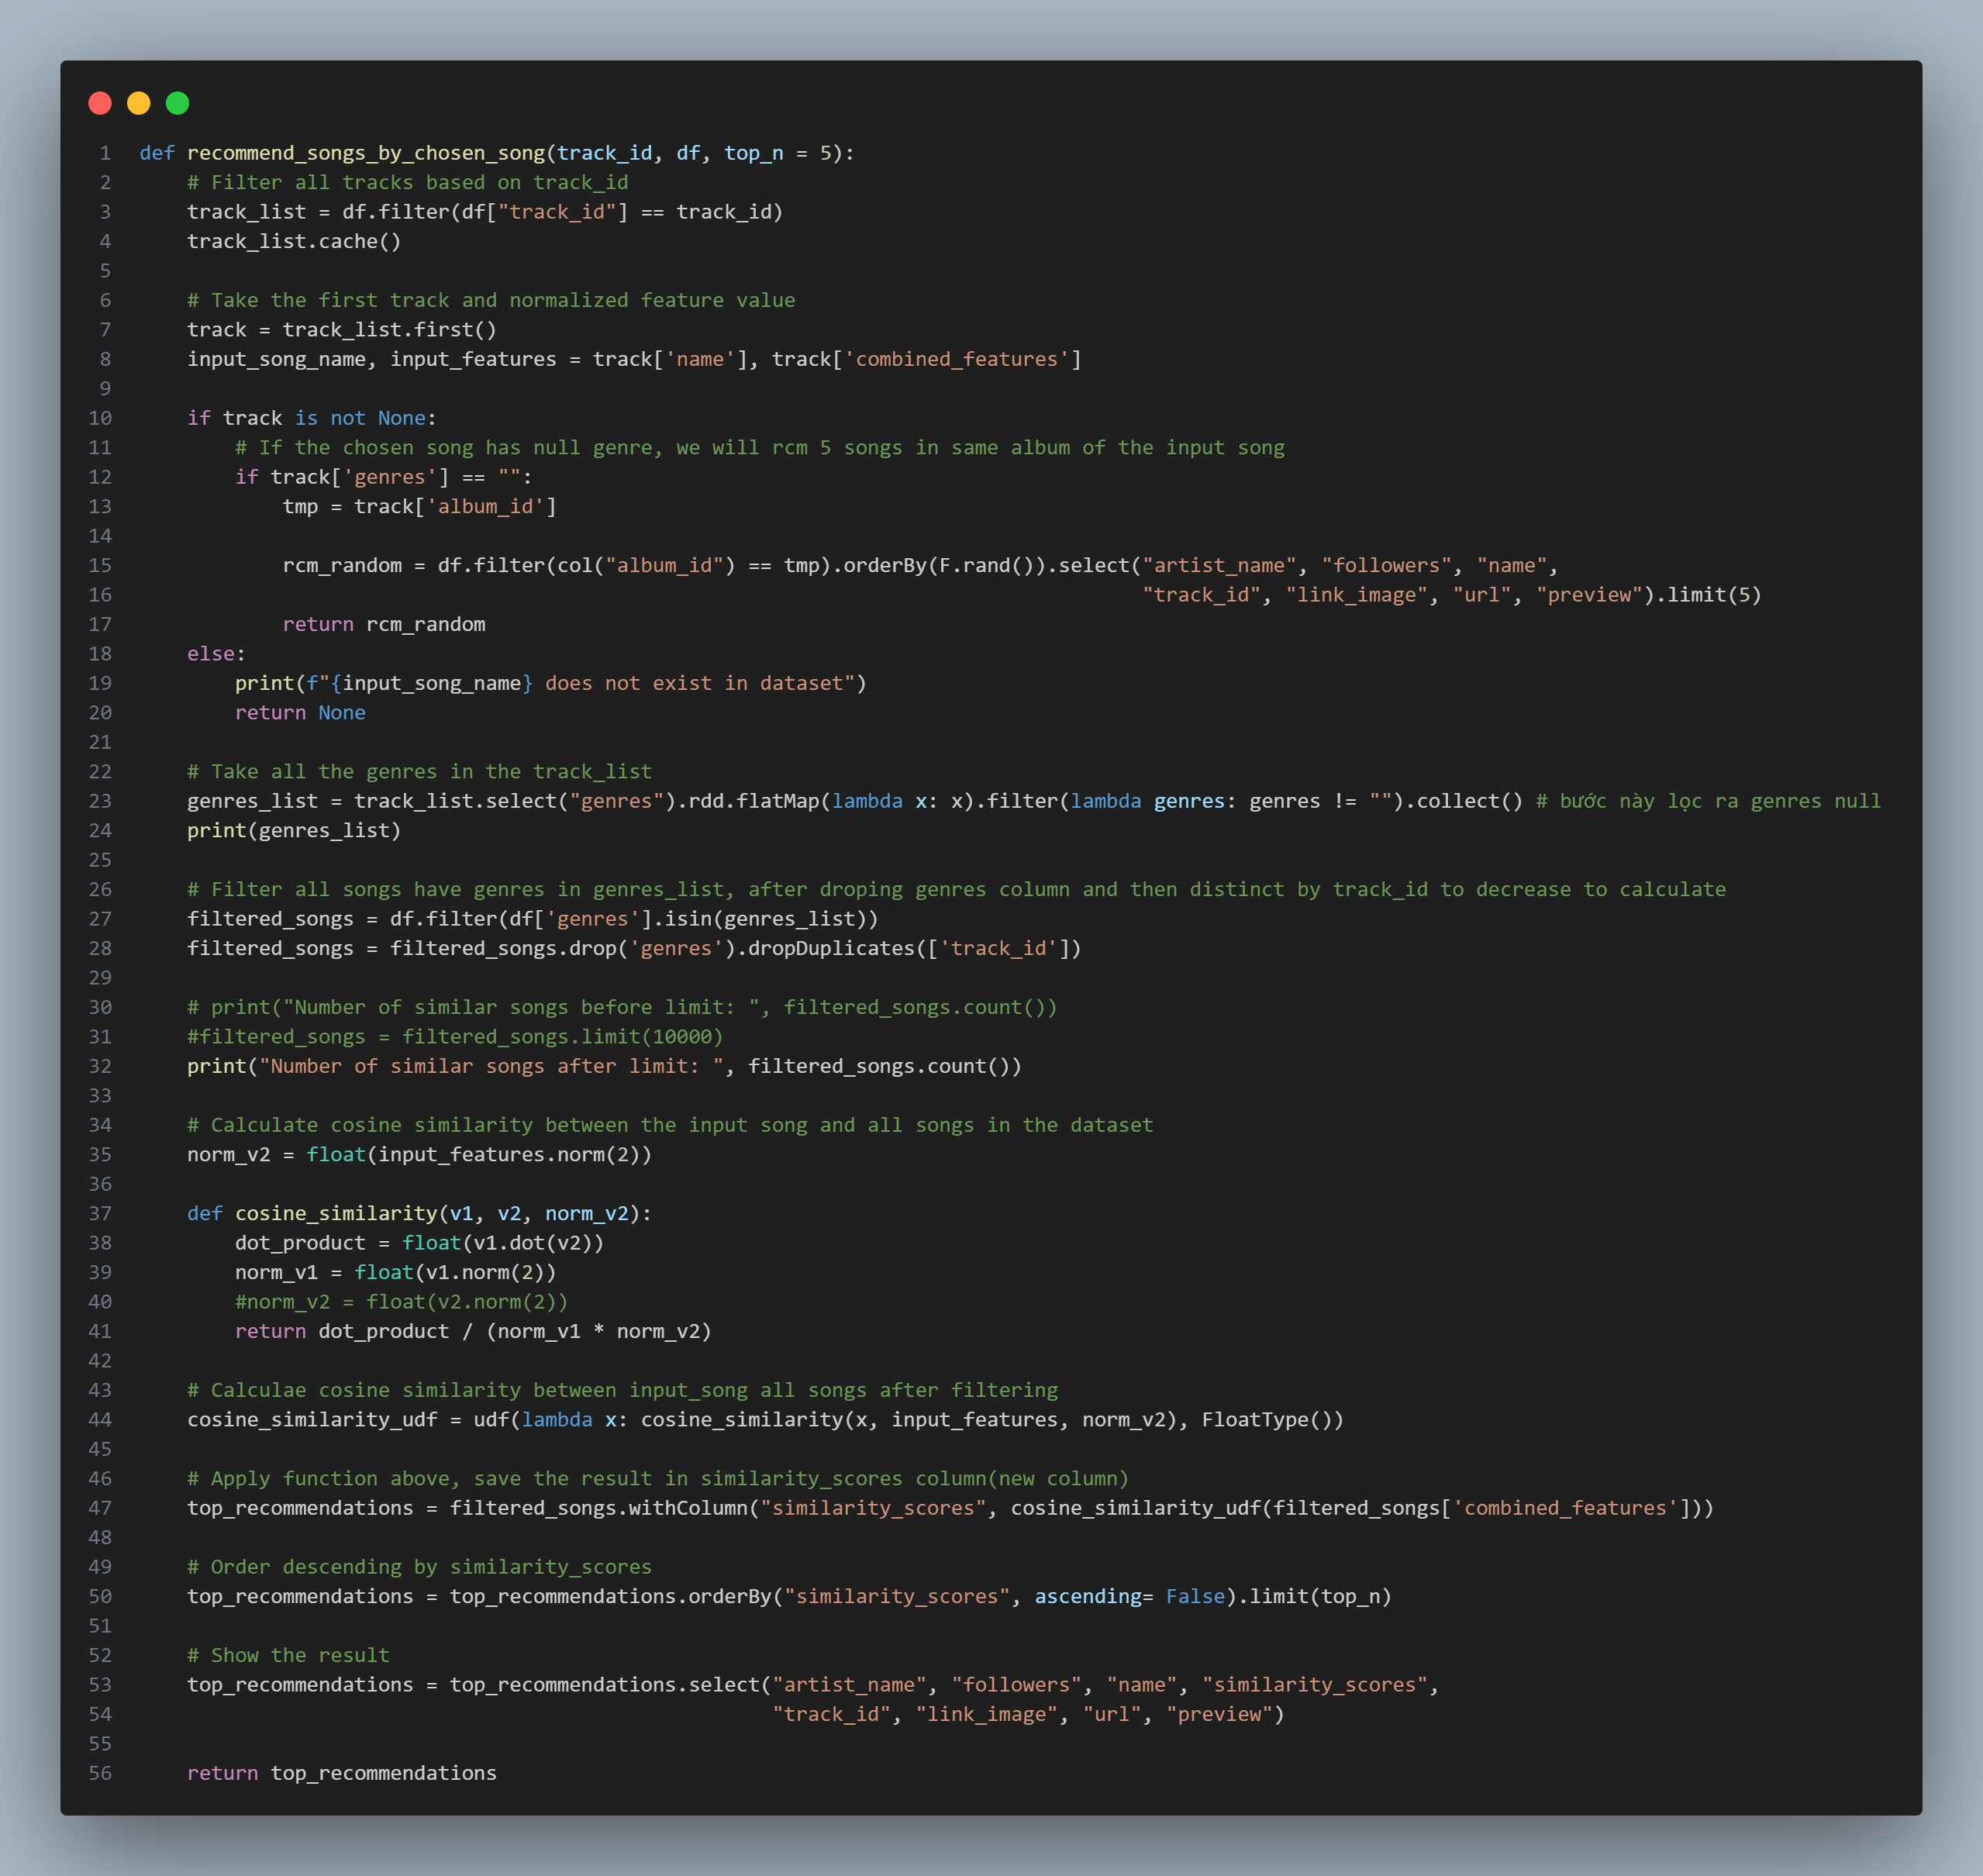


### Part 2.2: Build model using K-means clustering

#### Tổng quan về thuật toán:
+ **K-means** là một thuật toán học máy không giám sát được sử dụng để phân cụm dữ liệu thành các nhóm riêng biệt dựa trên tính tương đồng của các đặc điểm. Thuật toán này hoạt động theo chu kỳ để gán các điểm dữ liệu cho một trong k cụm bằng cách giảm thiểu phương sai trong mỗi cụm. Điều này làm cho thuật toán này đặc biệt hiệu quả để phân đoạn dữ liệu có các mẫu vốn có, chẳng hạn như nhóm các bản nhạc theo đặc điểm cảm xúc của chúng.

+ Đặc điểm chính của thuật toán:
    + Mỗi cụm được biểu diễn bằng tâm của cụm, được tính là giá trị trung bình của tất cả các điểm trong cụm
    + Số cụm k được xác định trước dựa trên các yêu cầu của bài toán
    + K-means đảm bảo rằng các điểm dữ liệu tương tự được nhóm lại với nhau, tạo điều kiện thuận lợi cho việc khám phá mẫu

#### Triển khai:
Mục tiêu chính của việc áp dụng **K-means** là phân loại các bản nhạc thành ba loại cảm xúc riêng biệt **- Happy, Sad và Neutral -** dựa trên các đặc điểm âm thanh của chúng. Việc phân cụm này cho phép đề xuất bài hát dựa trên tâm trạng cho người dùng.

- **Step 1:** Chúng tôi dùng **Z-score** ở đây với mục đích là chắc chắn tất cả những biến numerical mà tôi đã chọn sẽ về cùng 1 trọng số duy nhất để cho việc phân cụm. Nếu không chuẩn hóa, thì như tôi đã nói ở trên với thuật toán kia thì nó sẽ bị bias về 1 phía. Đây là công thức tính phía dưới để chuẩn hóa. Và ở đây **Z-score** làm được điều đó là nó sẽ đưa giá trị mean về 0 và standard deviation về 1 để chắc chắn rằng khi áp dụng **K-means** để phân cụm thì tất cả features đều cùng 1 range.

    ![Image](./images/Z_score.png)

    - Ở đây:
        - x: Original value
        - μ: Mean of data
        - σ: Standard deviation of data

- **Step 2:** Đầu tiên chúng tôi sẽ chọn ra những numerical audio features của 1 bài hát mà chúng tôi xem là quan trọng của 1 bài hát và dựa theo điều đó để label emotion cho bài hát đó là sẽ Happy, Sad, hay Neutral. Sau đó tôi sẽ áp dụng **K-means** và set k = 3 là tương đương với 3 vùng tượng trưng cho 3 cảm xúc mà tôi đã nêu, khi đó **K-means** sau khi phân cụm xong sẽ tính cái gọi là *centroid* của mỗi cụm để ta có thể nhìn vào đó để đánh giá và đặt label cho từng cảm xúc mà ta mong muốn. Đây là bảng thống kê mà **K-means** đã tình các **centroid** của từng vùng của mỗi audio features mà được chúng tôi chọn ra:

    ![Image](./images/k-means_output.png)

    - Theo bảng trên thì chúng tôi nhận thấy rằng với 1 bài nhạc có:
        - High valence, energy, and danceability thì chúng tôi sẽ quy ra là **Happy**
        - Low valence, energy, danceability but high accouticness thì sẽ được quy là **Sad**
        - Và còn lại sẽ là **Neutral**


- **Step 3:**
    - Sau khi phân loại được cảm xúc của từng bài nhạc, chúng tôi sẽ sử dụng phương pháp **Principal Component Analysis (PCA)**. Nói sơ qua về **PCA** 1 chút, thì **PCA** là 1 kỹ thuật giảm không gian chiều và thường xuyên được xử dụng để sử lý những big data. Nó sẽ chuyển đổi 1 **high-dimensional dataset**  thành 1 **lower-dimensional dataset**, những vẫn sẽ giữ lại những variability (hoặc thông tin) nhiều nhất có thể. Nhưng chính điều đó cũng sẽ là 1 điểm yếu rằng đánh đổi lại bằng độ chính xác của bài toán.

	- Tôi đã set trước để cho **PCA** giảm không gian chiều thành 2 components để phục vụ cho việc visualization trên hệ trục Oxy (không gian 2 chiều). Và ở đây tôi chỉ trích ra 1% của dữ liệu chính để vẽ cho mọi người có thể có 1 cái nhìn tổng quan hơn về dữ liệu sau khi tôi sử dụng **PCA**. Dưới đây là hình ảnh mà sau khi chúng tôi vẽ ra.

        ![Image](./images/PCA_visualization.png)


- **Step 4:** Tôi sẽ chia làm 2 trường hợp ở đây để tối ưu việc recommend nhạc nhất cho người dùng:

	+ **Case 1:** 
        - Người dùng sẽ nhập tâm trạng của họ ngay lúc đó và thể loại nhạc mà họ muốn nghe. Thì hệ thống của chúng tôi sẽ recommend ra những bài nhạc đúng tâm trạng của họ và cùng như là thể loại đúng như yêu cầu.

	+ **Case 2:** 
        - Người dùng cũng sẽ có thể nhập tâm trạng thôi và chúng tôi sẽ recommend ra những bài nhạc đúng với tâm trạng của họ lúc đó còn thể loại thì sẽ được ngẫu nhiên và sắp xếp theo những bài của người nổi tiếng nhất giảm dần xuống. Và ngược lại là người cũng có thể nhập thể loại mà mình muốn nghe thôi còn tâm trạng thì để trống thì chúng tôi sẽ recommend ra những bài đúng với thể loại nhạc mà người dùng đã nhập.

            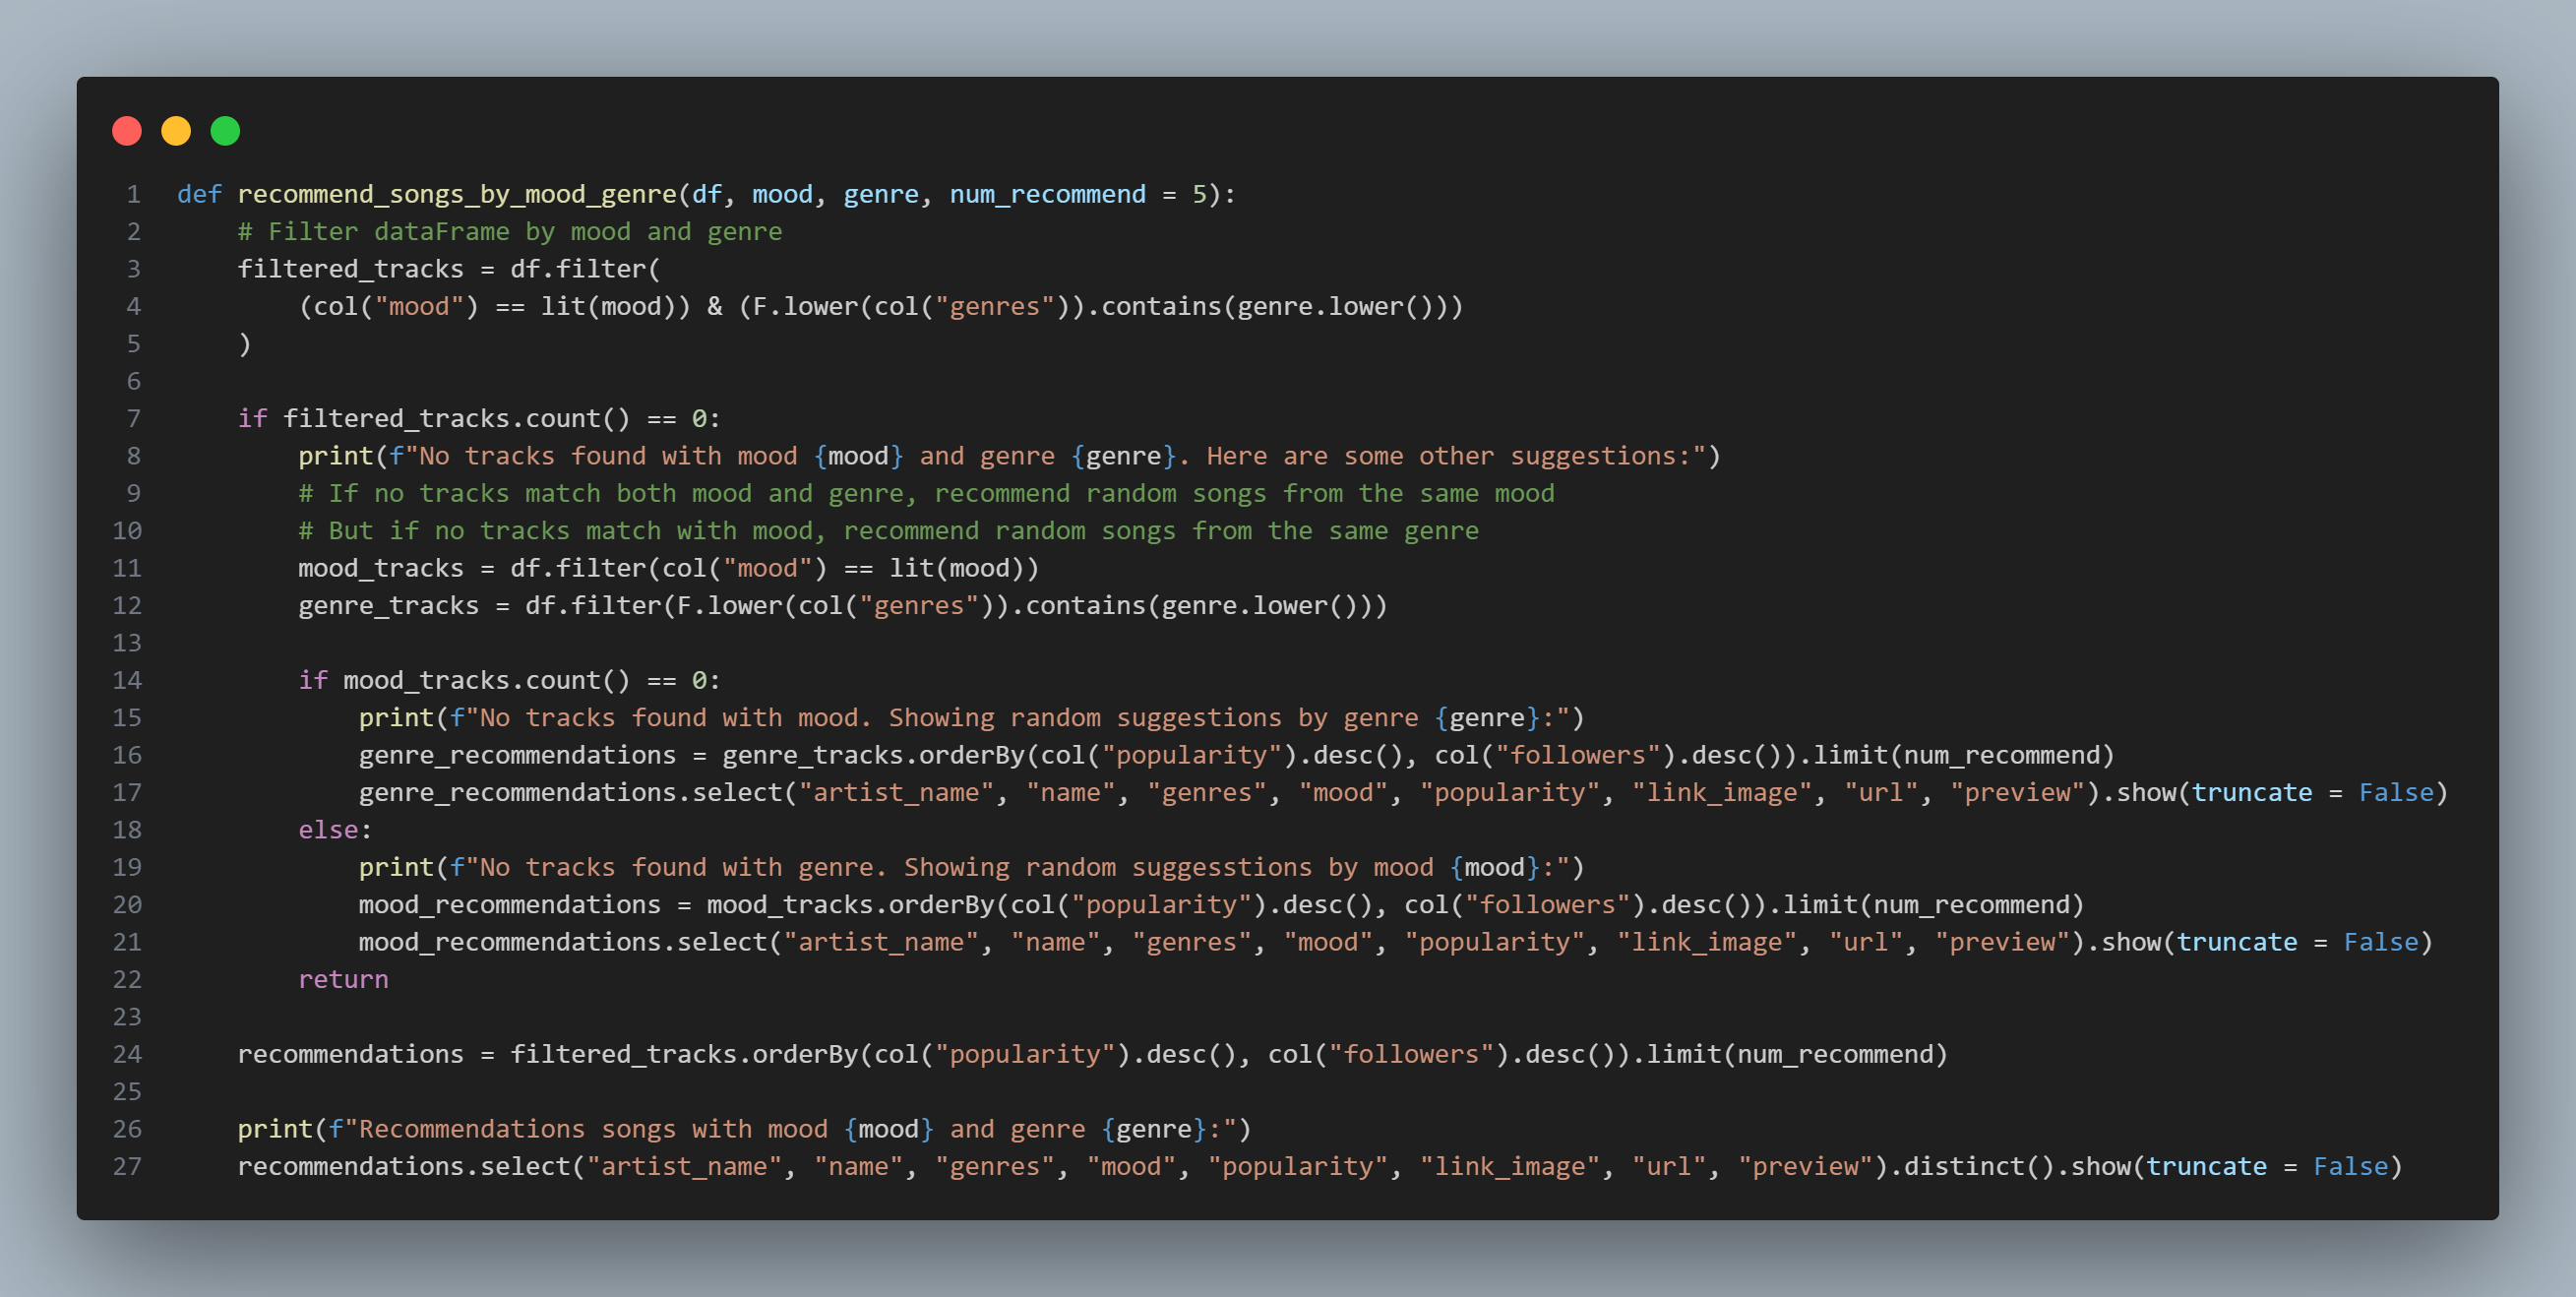